In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [2]:
df= pd.read_csv(r"ais_train.csv", delimiter='|')

FileNotFoundError: [Errno 2] No such file or directory: 'ais_train.csv'

In [4]:
df.head()

time    cog   sog  rot  heading  navstat       etaRaw  \
0  2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1  2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2  2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3  2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4  2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   

   latitude  longitude                  vesselId                    portId  
0 -34.74370  -57.85130  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07011a37f  
1   8.89440  -79.47939  61e9f3d4b937134a3c4bff1f  634c4de270937fc01c3a7689  
2  39.19065  -76.47567  61e9f436b937134a3c4c0131  61d3847bb7b7526e1adf3d19  
3 -34.41189  151.02067  61e9f3b4b937134a3c4bfe77  61d36f770a1807568ff9a126  
4  35.88379   -5.91636  61e9f41bb937134a3c4c0087  634c4de270937fc01c3a74f3

In [6]:
df.columns

Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId'],
      dtype='object')

In [7]:
df['rot']

0          0
1         -6
2          0
3          0
4          0
          ..
1522060    0
1522061    0
1522062   -1
1522063    0
1522064    5
Name: rot, Length: 1522065, dtype: int64

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Load the CSV data with the correct delimiter
df = pd.read_csv('ais_train.csv', delimiter='|')

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Handle non-numeric columns (like 'navstat', 'vesselId', 'portId')
df['navstat'] = pd.Categorical(df['navstat']).codes
df['vesselId'] = pd.Categorical(df['vesselId']).codes
df['portId'] = pd.Categorical(df['portId']).codes

# Drop rows with missing or invalid data
df = df.dropna(subset=['latitude', 'longitude', 'time'])

# Feature engineering: Add features for time-related data (day_of_week, hour)
df['day_of_week'] = df['time'].dt.dayofweek
df['hour'] = df['time'].dt.hour

# Create a folder to save plots if it doesn't already exist
plot_dir = "feature_importance_plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Shift latitude and longitude by 1 to 5 days (24, 48, 72, 96, 120 hours) to create multiple target columns
for days in range(1, 6):
    df[f'latitude_{days}day'] = df['latitude'].shift(-days * 24)
    df[f'longitude_{days}day'] = df['longitude'].shift(-days * 24)

# Drop rows where the target is NaN after shifting
df = df.dropna(subset=[f'latitude_{days}day' for days in range(1, 6)] + [f'longitude_{days}day' for days in range(1, 6)])

# Define features (X) - dropping time, current latitude, and current longitude (targets)
X = df.drop(columns=['latitude', 'longitude', 'time'] + [f'latitude_{days}day' for days in range(1, 6)] + [f'longitude_{days}day' for days in range(1, 6)])

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Train and evaluate models for each time horizon (1, 2, 3, 4, 5 days)
for days in range(1, 6):
    print(f"\n--- Predicting {days} day(s) into the future ---")

    # Define target (Y) for latitude and longitude for the current day horizon
    Y_latitude_future = df[f'latitude_{days}day']
    Y_longitude_future = df[f'longitude_{days}day']

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, Y_lat_train, Y_lat_test = train_test_split(X, Y_latitude_future, test_size=0.2, random_state=42)
    X_train, X_test, Y_lon_train, Y_lon_test = train_test_split(X, Y_longitude_future, test_size=0.2, random_state=42)

    # Initialize the RandomForestRegressor with progress bar
    n_estimators = 100
    rf_reg_lat = RandomForestRegressor(n_estimators=n_estimators, random_state=42, warm_start=True)
    rf_reg_lon = RandomForestRegressor(n_estimators=n_estimators, random_state=42, warm_start=True)

    # Train and display progress for latitude prediction
    for i in tqdm(range(1, n_estimators + 1), desc=f"Training RandomForest for Latitude ({days} days ahead)"):
        rf_reg_lat.set_params(n_estimators=i)
        rf_reg_lat.fit(X_train, Y_lat_train)

    # Train and display progress for longitude prediction
    for i in tqdm(range(1, n_estimators + 1), desc=f"Training RandomForest for Longitude ({days} days ahead)"):
        rf_reg_lon.set_params(n_estimators=i)
        rf_reg_lon.fit(X_train, Y_lon_train)

    # Make predictions on the test set for both latitude and longitude
    lat_predictions = rf_reg_lat.predict(X_test)
    lon_predictions = rf_reg_lon.predict(X_test)

    # Evaluate the model performance using Mean Squared Error
    lat_mse = mean_squared_error(Y_lat_test, lat_predictions)
    lon_mse = mean_squared_error(Y_lon_test, lon_predictions)
    print(f"Latitude Prediction MSE ({days} days ahead): {lat_mse}")
    print(f"Longitude Prediction MSE ({days} days ahead): {lon_mse}")

    # Get feature importances from the RandomForestRegressor (latitude)
    importances_lat = rf_reg_lat.feature_importances_
    feature_names = X.columns

    # Sort feature importances in descending order
    indices_lat = np.argsort(importances_lat)[::-1]

    # Print feature importances for latitude prediction
    print(f"Feature ranking for Latitude Prediction ({days} days ahead):")
    for i in range(X.shape[1]):
        print(f"{i + 1}. feature {feature_names[indices_lat[i]]} ({importances_lat[indices_lat[i]]})")

    # Plot the feature importances for latitude prediction
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance - Predicting Latitude ({days} Days Ahead)")
    plt.bar(range(X.shape[1]), importances_lat[indices_lat], align="center")
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices_lat], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()

    # Save the plot to a file instead of showing it
    plt.savefig(f"{plot_dir}/feature_importance_latitude_{days}days.png")
    plt.close()

    # Get feature importances for longitude prediction and save a similar plot
    importances_lon = rf_reg_lon.feature_importances_
    indices_lon = np.argsort(importances_lon)[::-1]

    # Plot the feature importances for longitude prediction
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance - Predicting Longitude ({days} Days Ahead)")
    plt.bar(range(X.shape[1]), importances_lon[indices_lon], align="center")
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices_lon], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()

    # Save the plot to a file instead of showing it
    plt.savefig(f"{plot_dir}/feature_importance_longitude_{days}days.png")
    plt.close()

print(f"\nAll plots saved in the directory: {plot_dir}")



--- Predicting 1 day(s) into the future ---


Training RandomForest for Latitude (1 days ahead): 100%|██████████| 100/100 [12:15<00:00,  7.35s/it]
Training RandomForest for Longitude (1 days ahead): 100%|██████████| 100/100 [12:57<00:00,  7.78s/it]


Latitude Prediction MSE (1 days ahead): 614.1055606099266
Longitude Prediction MSE (1 days ahead): 5471.522224099197
Feature ranking for Latitude Prediction (1 days ahead):
1. feature cog (0.24242472089124392)
2. feature heading (0.15534685023833364)
3. feature hour (0.1504685987586382)
4. feature vesselId (0.12689306904524217)
5. feature sog (0.11104635065661848)
6. feature portId (0.09535087916215673)
7. feature rot (0.058099563167649255)
8. feature day_of_week (0.05176363386480102)
9. feature navstat (0.008606334215316728)
10. feature etaRaw (0.0)

--- Predicting 2 day(s) into the future ---


Training RandomForest for Latitude (2 days ahead): 100%|██████████| 100/100 [12:12<00:00,  7.32s/it]
Training RandomForest for Longitude (2 days ahead): 100%|██████████| 100/100 [12:26<00:00,  7.47s/it]


Latitude Prediction MSE (2 days ahead): 614.1813019745539
Longitude Prediction MSE (2 days ahead): 5464.8876188432805
Feature ranking for Latitude Prediction (2 days ahead):
1. feature cog (0.2448042743741049)
2. feature heading (0.15371271474630765)
3. feature hour (0.15103824128336937)
4. feature vesselId (0.12245965599133642)
5. feature sog (0.12204948512108742)
6. feature portId (0.08813362593657434)
7. feature rot (0.06003633773933019)
8. feature day_of_week (0.052348694629162626)
9. feature navstat (0.005416970178727152)
10. feature etaRaw (0.0)

--- Predicting 3 day(s) into the future ---


Training RandomForest for Latitude (3 days ahead): 100%|██████████| 100/100 [12:04<00:00,  7.25s/it]
Training RandomForest for Longitude (3 days ahead): 100%|██████████| 100/100 [12:26<00:00,  7.46s/it]


Latitude Prediction MSE (3 days ahead): 610.9338869936907
Longitude Prediction MSE (3 days ahead): 5470.242528098053
Feature ranking for Latitude Prediction (3 days ahead):
1. feature cog (0.24626801266885767)
2. feature heading (0.15752482699044887)
3. feature vesselId (0.1302409709044944)
4. feature hour (0.12673504565360277)
5. feature sog (0.12245990602302709)
6. feature portId (0.09870651130205706)
7. feature rot (0.059976336096687705)
8. feature day_of_week (0.052901892831038765)
9. feature navstat (0.005186497529785637)
10. feature etaRaw (0.0)

--- Predicting 4 day(s) into the future ---


Training RandomForest for Latitude (4 days ahead): 100%|██████████| 100/100 [12:23<00:00,  7.44s/it]
Training RandomForest for Longitude (4 days ahead): 100%|██████████| 100/100 [12:19<00:00,  7.40s/it]


Latitude Prediction MSE (4 days ahead): 613.63043751347
Longitude Prediction MSE (4 days ahead): 5486.929546298273
Feature ranking for Latitude Prediction (4 days ahead):
1. feature cog (0.24575494364094325)
2. feature heading (0.15733762323565795)
3. feature hour (0.13312906066015587)
4. feature vesselId (0.12933927761582498)
5. feature sog (0.11896160627162086)
6. feature portId (0.10042941612212715)
7. feature rot (0.060113128141948025)
8. feature day_of_week (0.04432645961728816)
9. feature navstat (0.010608484694433817)
10. feature etaRaw (0.0)

--- Predicting 5 day(s) into the future ---


Training RandomForest for Latitude (5 days ahead): 100%|██████████| 100/100 [12:08<00:00,  7.29s/it]
Training RandomForest for Longitude (5 days ahead): 100%|██████████| 100/100 [12:44<00:00,  7.64s/it]


Latitude Prediction MSE (5 days ahead): 614.2485477236579
Longitude Prediction MSE (5 days ahead): 5473.578083245362
Feature ranking for Latitude Prediction (5 days ahead):
1. feature cog (0.2465354045451301)
2. feature hour (0.1520935950738248)
3. feature heading (0.1515230797734801)
4. feature vesselId (0.1242295147219063)
5. feature sog (0.11674045421162793)
6. feature portId (0.09246869852224018)
7. feature rot (0.05821912722991408)
8. feature day_of_week (0.04900577351997898)
9. feature navstat (0.00918435240189761)
10. feature etaRaw (0.0)

All plots saved in the directory: feature_importance_plots


Training RandomForest: 100%|██████████| 100/100 [10:00<00:00,  6.01s/it]


Latitude Prediction MSE: 2.4470879134986765
Feature ranking:
1. feature portId (0.9253090599154282)
2. feature vesselId (0.04180173997232745)
3. feature heading (0.009765101809237575)
4. feature sog (0.008917972610830698)
5. feature cog (0.005544965561374424)
6. feature navstat (0.0038410734870768432)
7. feature day_of_week (0.0026136257202222734)
8. feature hour (0.0015246778325754542)
9. feature rot (0.0006817830909270569)
10. feature etaRaw (0.0)


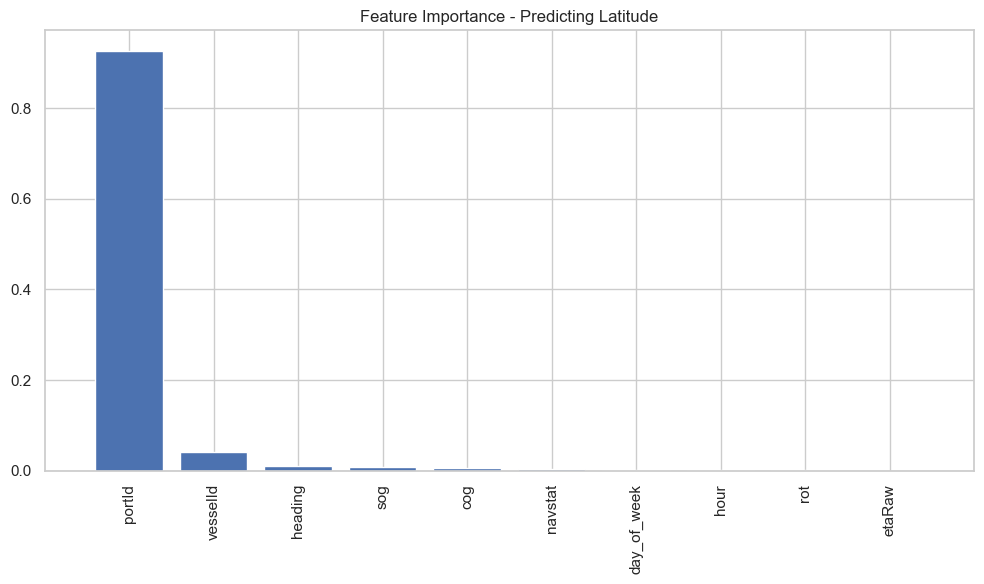

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # For progress bar

# Load the CSV data with the correct delimiter
df = pd.read_csv('ais_train.csv', delimiter='|')

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')  # handle any conversion errors

# Handle non-numeric columns (like 'navstat', 'vesselId', 'portId')
df['navstat'] = pd.Categorical(df['navstat']).codes
df['vesselId'] = pd.Categorical(df['vesselId']).codes
df['portId'] = pd.Categorical(df['portId']).codes

# Drop rows with missing or invalid data
df = df.dropna(subset=['latitude', 'longitude', 'time'])

# Feature engineering: Add features for time-related data (day_of_week, hour)
df['day_of_week'] = df['time'].dt.dayofweek
df['hour'] = df['time'].dt.hour

# Define features (X) - dropping time, latitude, longitude (targets)
X = df.drop(columns=['latitude', 'longitude', 'time'])

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Define target (Y) - Predicting latitude and longitude
Y_latitude = df['latitude']
Y_longitude = df['longitude']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, Y_lat_train, Y_lat_test = train_test_split(X, Y_latitude, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor with progress bar
n_estimators = 100
rf_reg = RandomForestRegressor(n_estimators=n_estimators, random_state=42, warm_start=True)

# Use tqdm for the progress bar
for i in tqdm(range(1, n_estimators + 1), desc="Training RandomForest"):
    rf_reg.set_params(n_estimators=i)
    rf_reg.fit(X_train, Y_lat_train)

# Make predictions on the test set
lat_predictions = rf_reg.predict(X_test)

# Evaluate the model performance using Mean Squared Error
lat_mse = mean_squared_error(Y_lat_test, lat_predictions)
print(f"Latitude Prediction MSE: {lat_mse}")

# Get feature importances from the RandomForestRegressor
importances = rf_reg.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print feature importances
print("Feature ranking:")

for i in range(X.shape[1]):
    print(f"{i + 1}. feature {feature_names[indices[i]]} ({importances[indices[i]]})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Predicting Latitude")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


Data loaded successfully.

First 5 rows of the dataset:
                  time    cog   sog  rot  heading  navstat       etaRaw  \
0  2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1  2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2  2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3  2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4  2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   

   latitude  longitude                  vesselId                    portId  
0 -34.74370  -57.85130  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07011a37f  
1   8.89440  -79.47939  61e9f3d4b937134a3c4bff1f  634c4de270937fc01c3a7689  
2  39.19065  -76.47567  61e9f436b937134a3c4c0131  61d3847bb7b7526e1adf3d19  
3 -34.41189  151.02067  61e9f3b4b937134a3c4bfe77  61d36f770a1807568ff9a126  
4  35.88379   -5.91636  61e9f41bb937134a3c4c0087  634c4de270937fc01c3a74f3  

Data Information:
<class 'pand

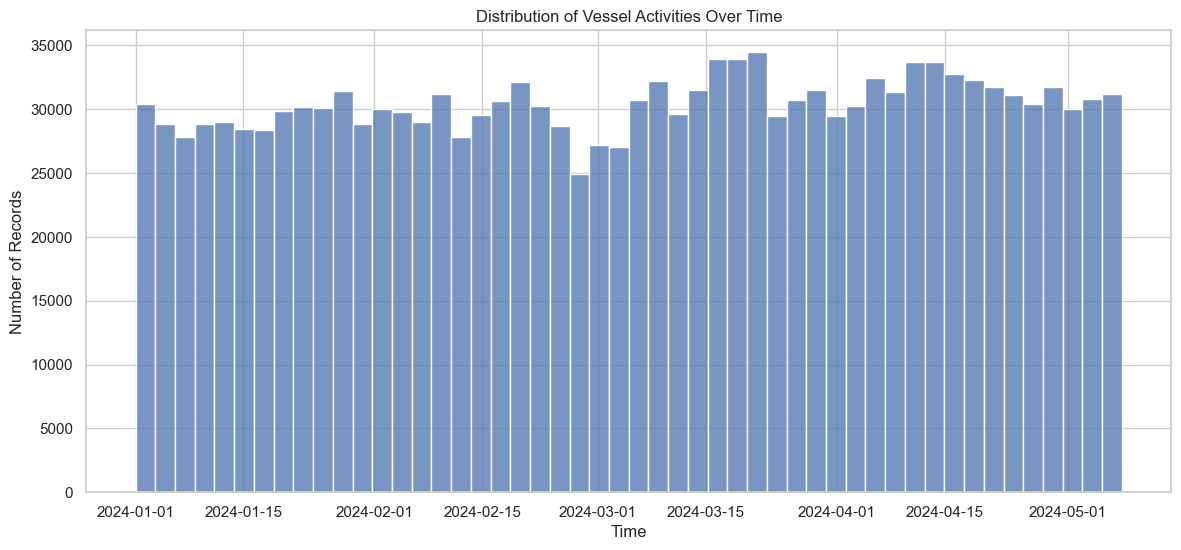

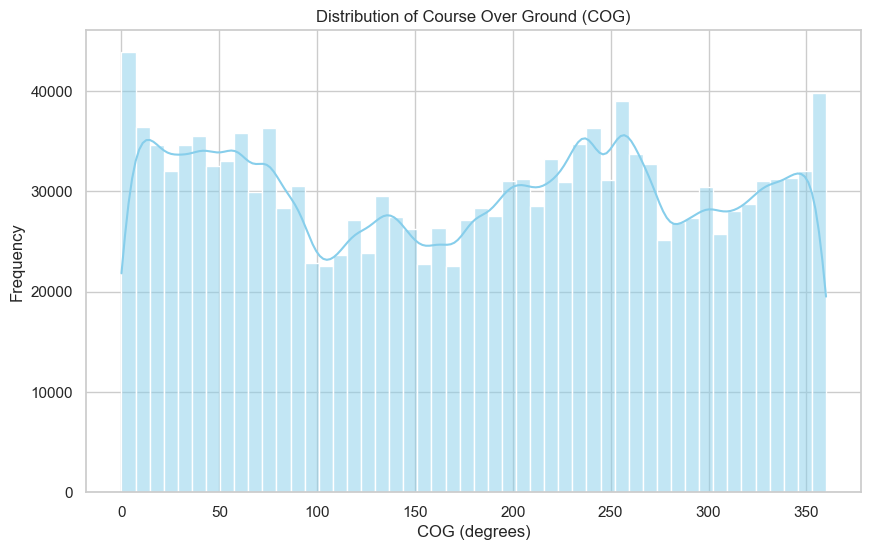

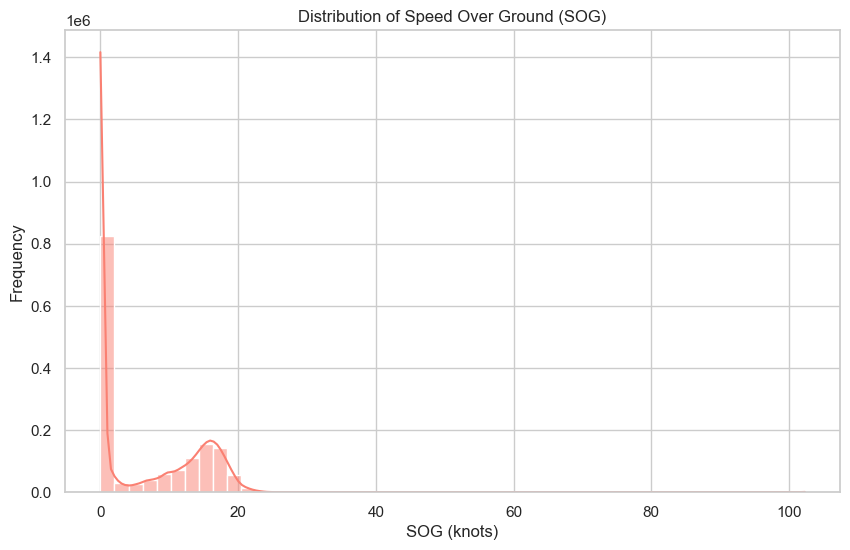

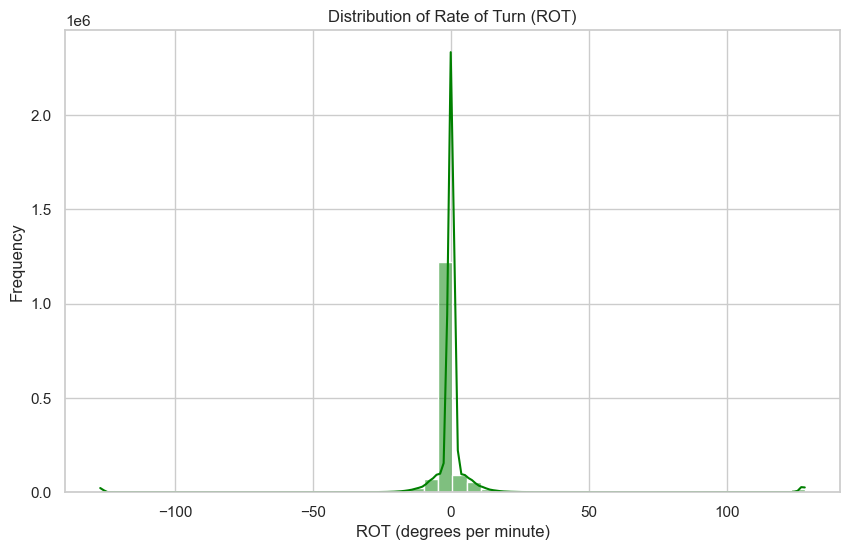

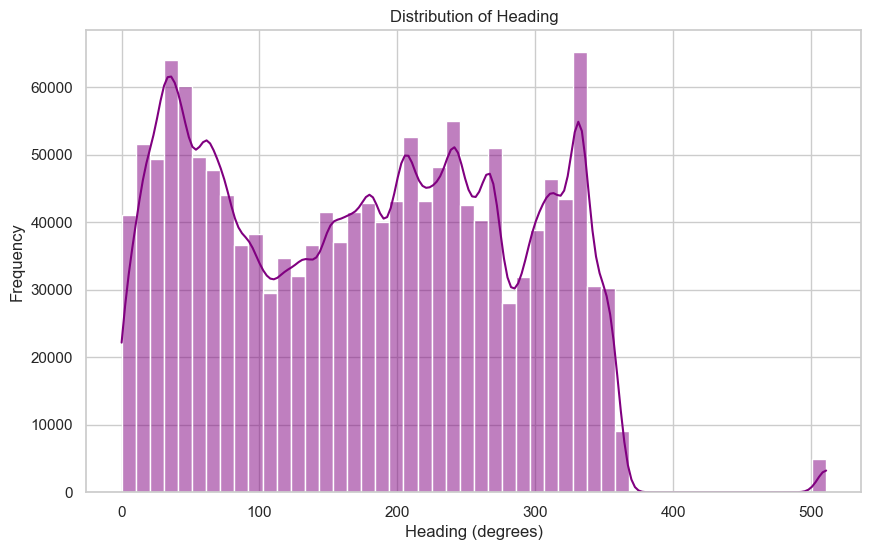


Navigation Status Value Counts:
navstat
0     782099
5     605831
1     129515
2       2081
8        948
15       670
6        521
4        232
3        161
11         2
13         1
12         1
14         1
7          1
9          1
Name: count, dtype: int64


C:\Users\marvaar\AppData\Local\Temp\ipykernel_18700\2324622654.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='navstat', data=df, palette='viridis')


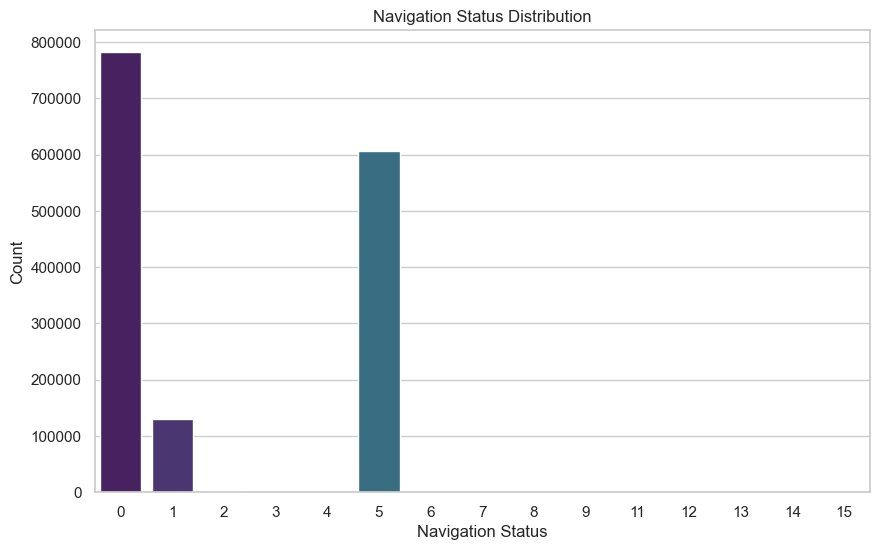


Converting 'etaRaw' to datetime format.


C:\Users\marvaar\AppData\Local\Temp\ipykernel_18700\2324622654.py:101: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['etaRaw'] = pd.to_datetime(df['etaRaw'], errors='coerce')


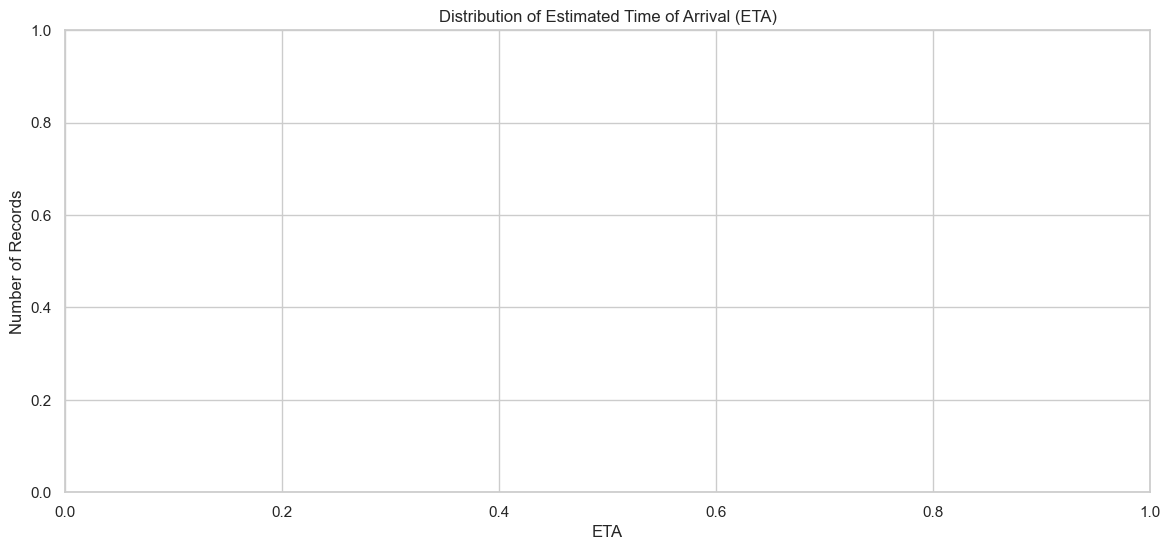

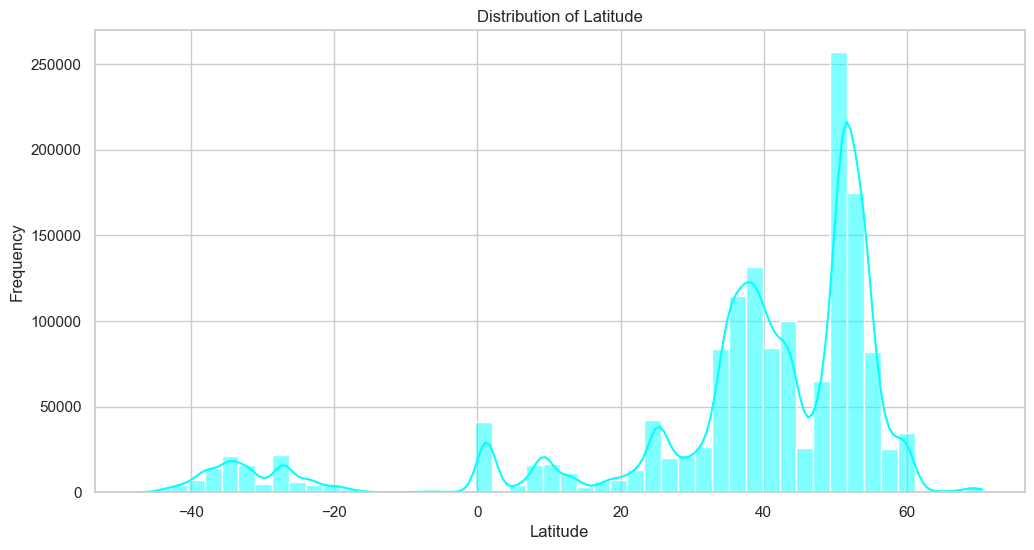

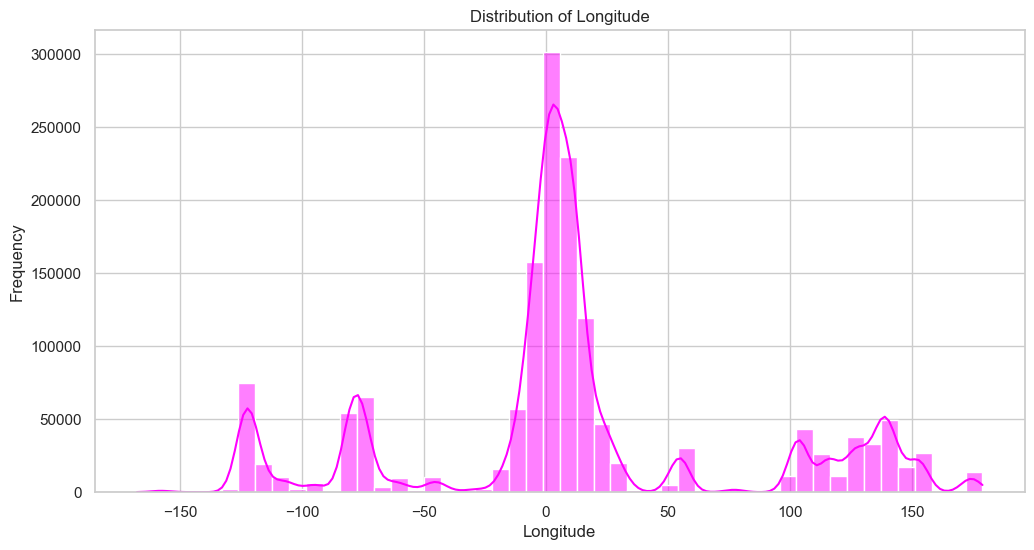


Unique Vessel IDs: 688
Unique Port IDs: 772


C:\Users\marvaar\AppData\Local\Temp\ipykernel_18700\2324622654.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vessels.index, y=top_vessels.values, palette='magma')


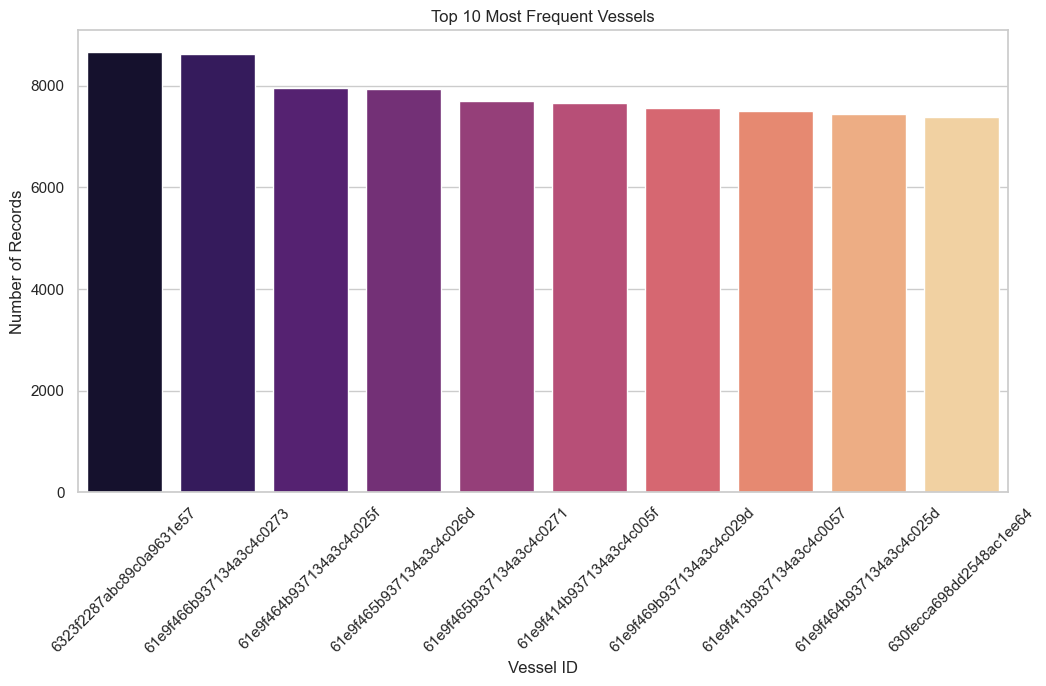

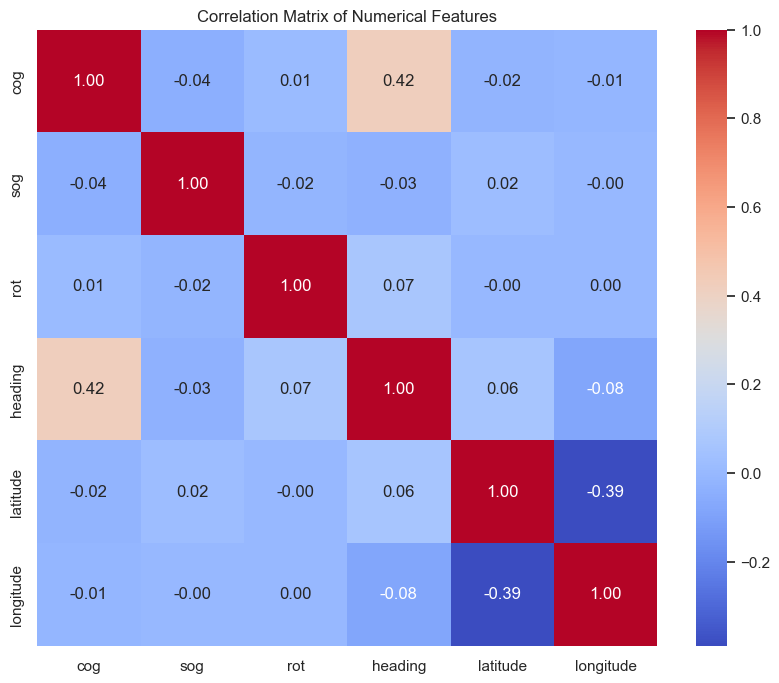

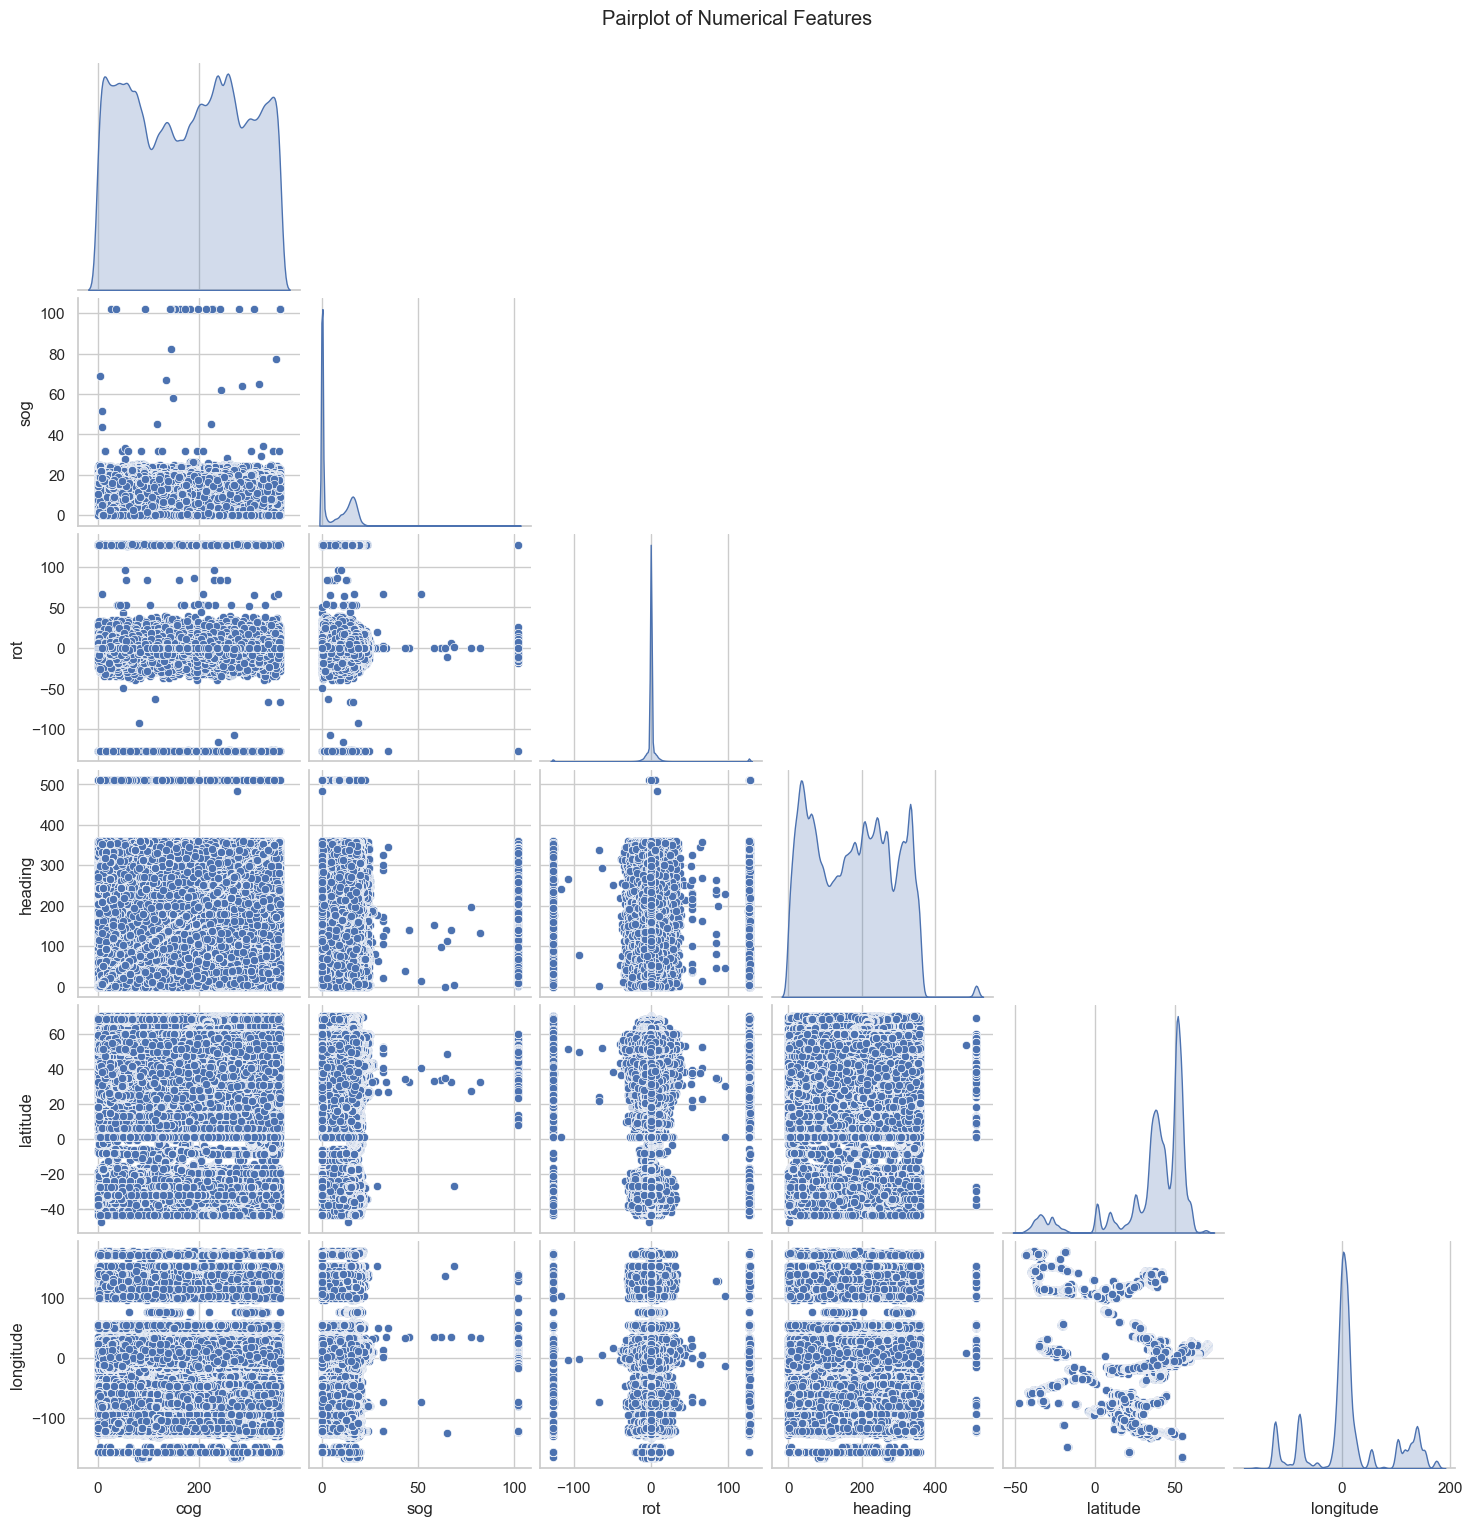

C:\Users\marvaar\AppData\Local\Temp\ipykernel_18700\2324622654.py:158: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='time', y='sog', data=df, ci=None, color='blue')


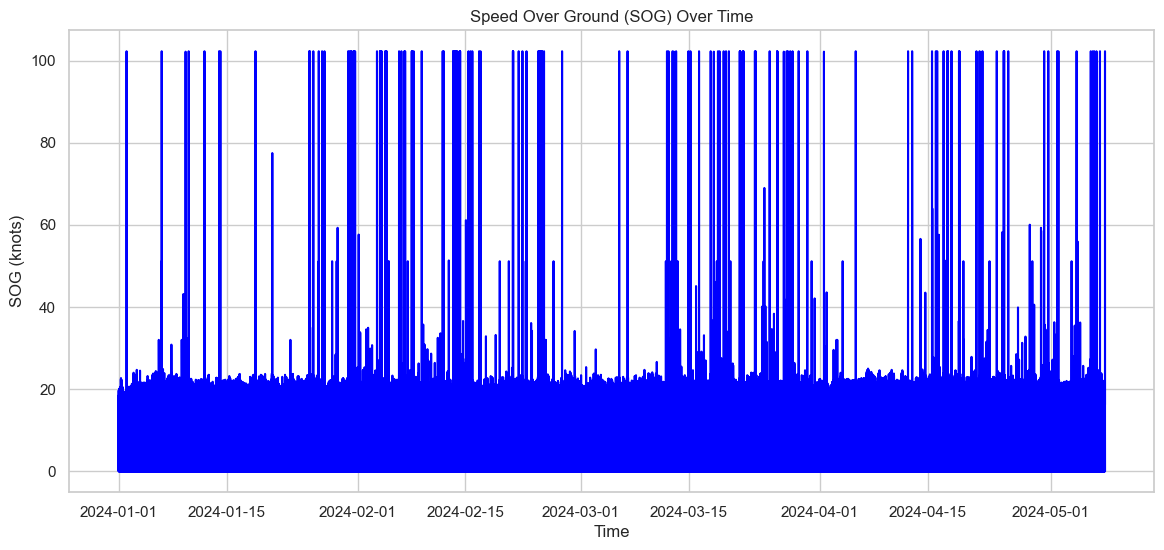

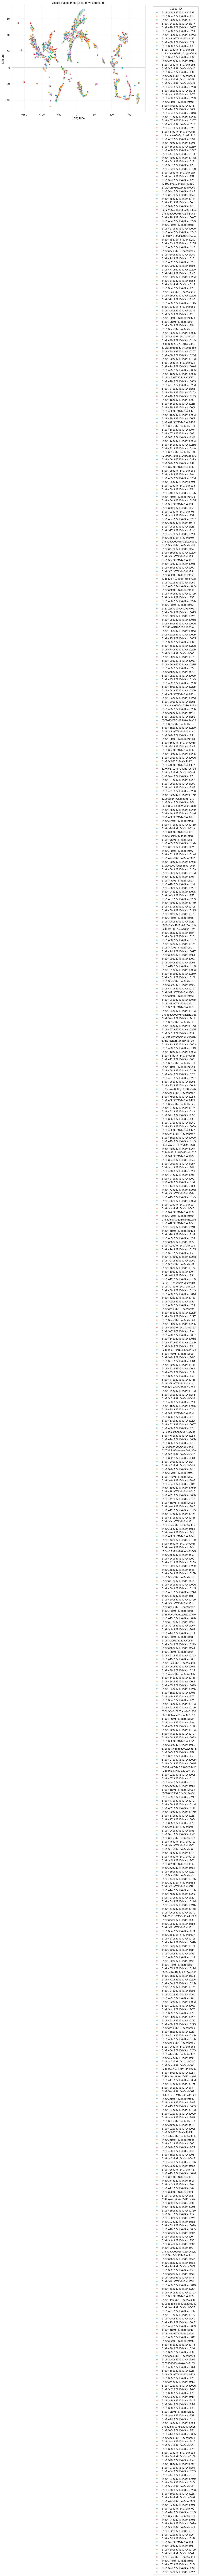

c:\Users\marvaar\Desktop\tdt4173\tdt4173_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


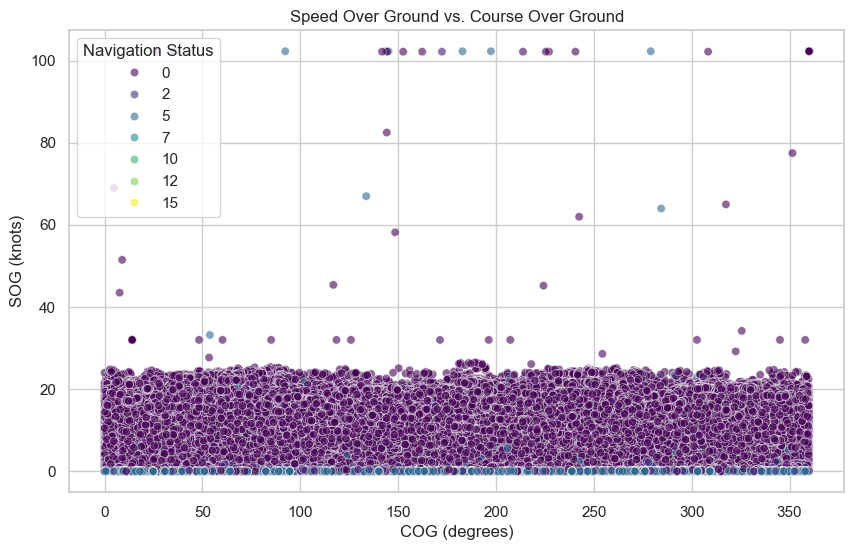


Missing Values Before Cleaning:
time               0
cog                0
sog                0
rot                0
heading            0
navstat            0
etaRaw       1522065
latitude           0
longitude          0
vesselId           0
portId          1615
dtype: int64


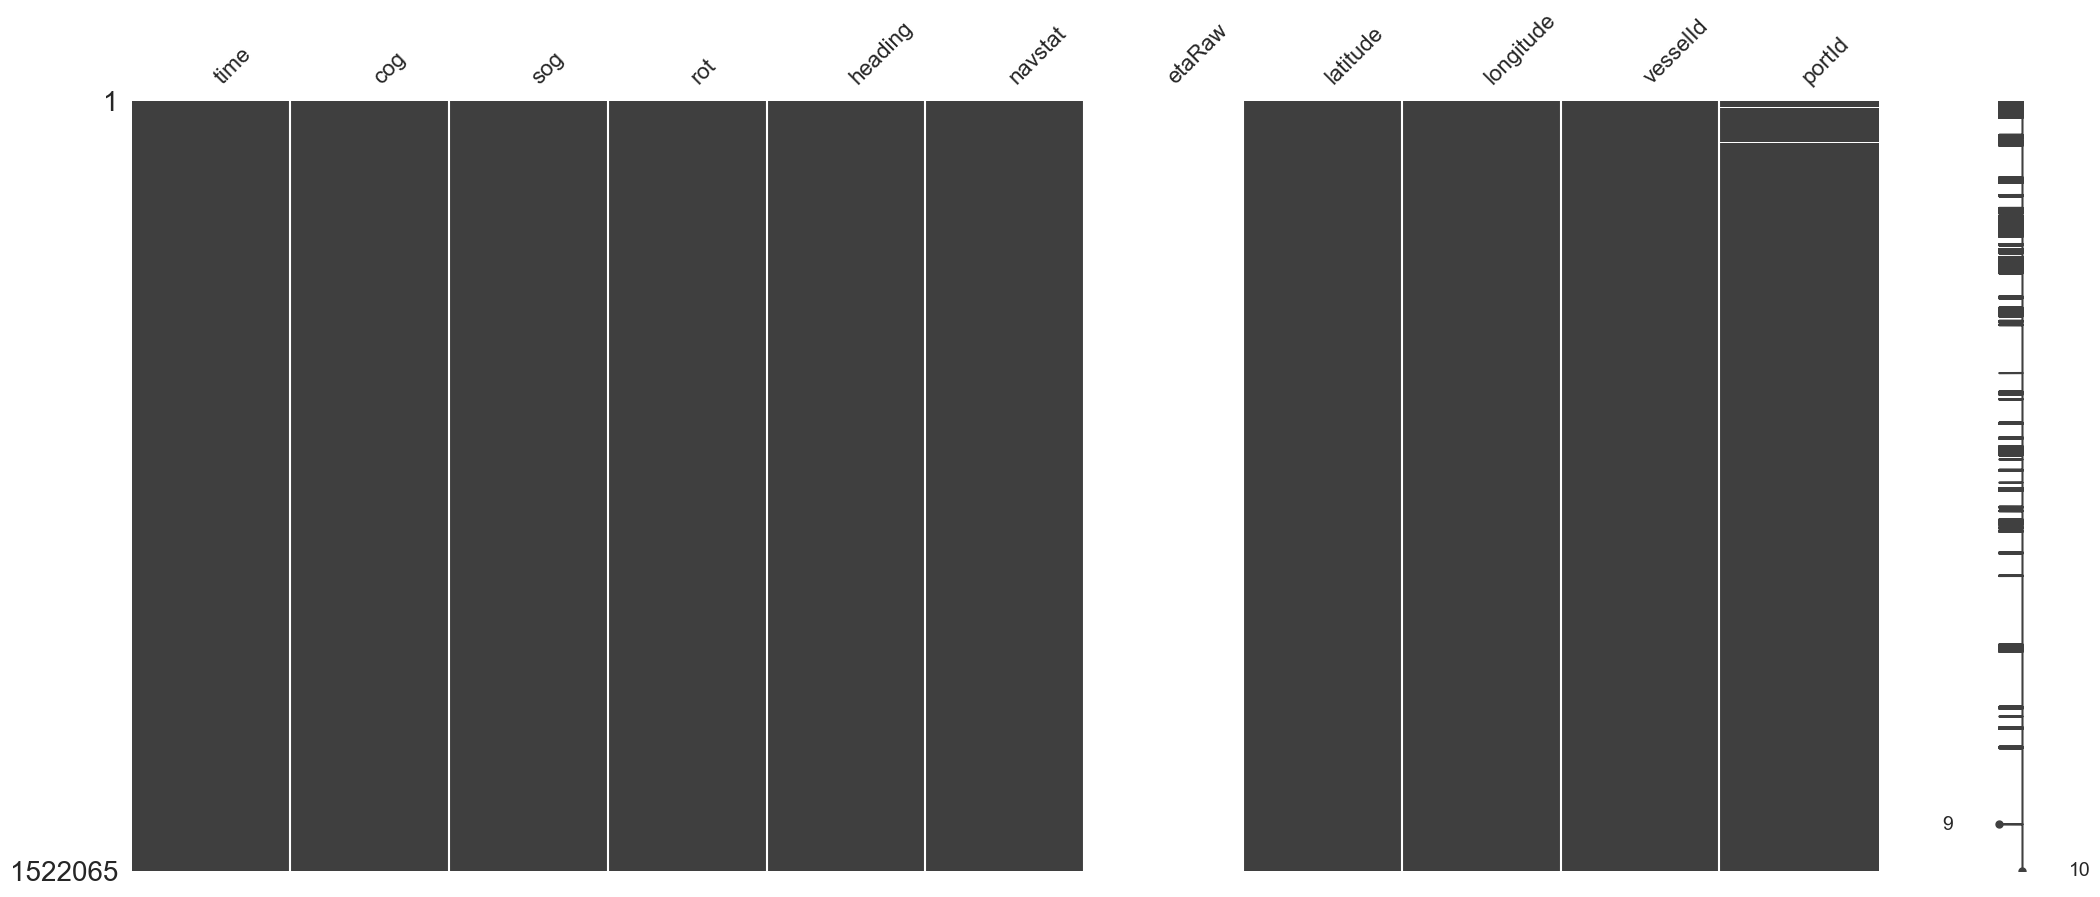


Missing Values After Cleaning:
time               0
cog                0
sog                0
rot                0
heading            0
navstat            0
etaRaw       1522065
latitude           0
longitude          0
vesselId           0
portId          1615
dtype: int64
Removed 417 outliers from 'sog'.
Removed 0 outliers from 'cog'.

Data Cleaning Completed. Cleaned DataFrame shape: (1521648, 24)
Cleaned data saved to ais_test_cleaned.csv.


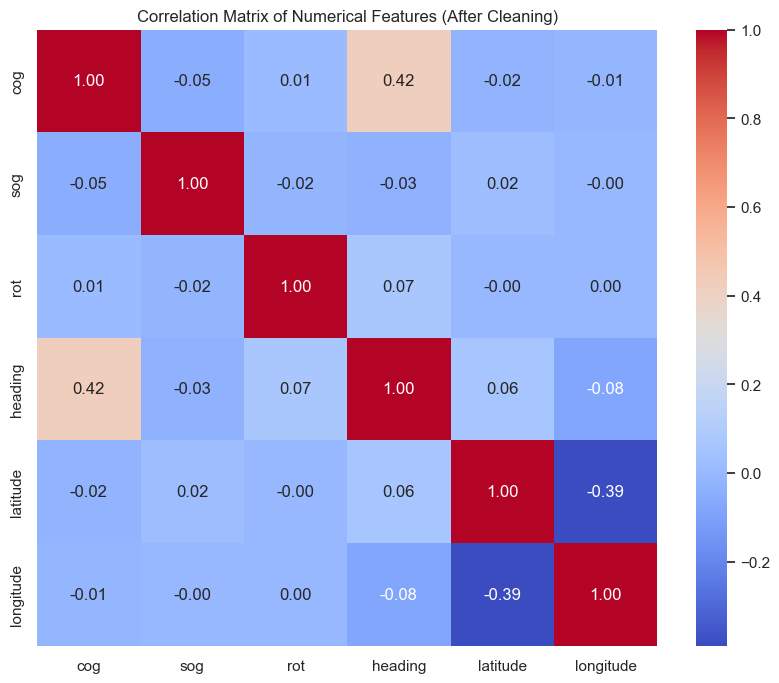

In [6]:
# This is when I plugged the three last point into chat

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

# Set visualization styles
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Load the Data
# ----------------

# Define the file path (update if necessary)
file_path = 'ais_train.csv'

# Read the CSV file with '|' as delimiter
try:
    df = pd.read_csv(file_path, delimiter='|')
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File {file_path} not found. Please check the path and try again.")

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display data types and non-null counts
print("\nData Information:")
print(df.info())

# Display summary statistics for numerical features
print("\nSummary Statistics for Numerical Features:")
print(df.describe())

# 2. Exploring Individual Features
# --------------------------------

# a. Time Feature
print("\nConverting 'time' to datetime format.")
df['time'] = pd.to_datetime(df['time'], errors='coerce')
print("Date range:", df['time'].min(), "to", df['time'].max())

# Plot the distribution of vessel activities over time
plt.figure(figsize=(14,6))
sns.histplot(df['time'], bins=50, kde=False)
plt.title('Distribution of Vessel Activities Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Records')
plt.show()

# b. COG (Course Over Ground)
plt.figure(figsize=(10,6))
sns.histplot(df['cog'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Distribution of Course Over Ground (COG)')
plt.xlabel('COG (degrees)')
plt.ylabel('Frequency')
plt.show()

# c. SOG (Speed Over Ground)
plt.figure(figsize=(10,6))
sns.histplot(df['sog'].dropna(), bins=50, kde=True, color='salmon')
plt.title('Distribution of Speed Over Ground (SOG)')
plt.xlabel('SOG (knots)')
plt.ylabel('Frequency')
plt.show()

# d. ROT (Rate of Turn)
plt.figure(figsize=(10,6))
sns.histplot(df['rot'].dropna(), bins=50, kde=True, color='green')
plt.title('Distribution of Rate of Turn (ROT)')
plt.xlabel('ROT (degrees per minute)')
plt.ylabel('Frequency')
plt.show()

# e. Heading
plt.figure(figsize=(10,6))
sns.histplot(df['heading'].dropna(), bins=50, kde=True, color='purple')
plt.title('Distribution of Heading')
plt.xlabel('Heading (degrees)')
plt.ylabel('Frequency')
plt.show()

# f. Navigation Status (navstat)
print("\nNavigation Status Value Counts:")
print(df['navstat'].value_counts())

# Plot navigation status distribution
plt.figure(figsize=(10,6))
sns.countplot(x='navstat', data=df, palette='viridis')
plt.title('Navigation Status Distribution')
plt.xlabel('Navigation Status')
plt.ylabel('Count')
plt.show()

# g. Estimated Time of Arrival (etaRaw)
# Assuming etaRaw is a string representing datetime
print("\nConverting 'etaRaw' to datetime format.")
df['etaRaw'] = pd.to_datetime(df['etaRaw'], errors='coerce')

plt.figure(figsize=(14,6))
sns.histplot(df['etaRaw'].dropna(), bins=50, kde=False, color='orange')
plt.title('Distribution of Estimated Time of Arrival (ETA)')
plt.xlabel('ETA')
plt.ylabel('Number of Records')
plt.show()

# h. Latitude and Longitude
plt.figure(figsize=(12,6))
sns.histplot(df['latitude'].dropna(), bins=50, kde=True, color='cyan')
plt.title('Distribution of Latitude')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(df['longitude'].dropna(), bins=50, kde=True, color='magenta')
plt.title('Distribution of Longitude')
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.show()

# i. Vessel ID and Port ID
print("\nUnique Vessel IDs:", df['vesselId'].nunique())
print("Unique Port IDs:", df['portId'].nunique())

# Plot top 10 most frequent vessels
plt.figure(figsize=(12,6))
top_vessels = df['vesselId'].value_counts().nlargest(10)
sns.barplot(x=top_vessels.index, y=top_vessels.values, palette='magma')
plt.title('Top 10 Most Frequent Vessels')
plt.xlabel('Vessel ID')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.show()

# 3. Exploring Pairs and Groups of Features
# ------------------------------------------

# a. Correlation Matrix for Numerical Features
numerical_features = ['cog', 'sog', 'rot', 'heading', 'latitude', 'longitude']
corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# b. Pairplot
sns.pairplot(df[numerical_features].dropna(), diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

# c. Time vs. SOG
plt.figure(figsize=(14,6))
sns.lineplot(x='time', y='sog', data=df, ci=None, color='blue')
plt.title('Speed Over Ground (SOG) Over Time')
plt.xlabel('Time')
plt.ylabel('SOG (knots)')
plt.show()

# d. Latitude vs. Longitude (Vessel Trajectory)
plt.figure(figsize=(10,8))
sns.scatterplot(x='longitude', y='latitude', hue='vesselId', palette='tab10', alpha=0.5, data=df)
plt.title('Vessel Trajectories (Latitude vs Longitude)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Vessel ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# e. SOG vs. COG
plt.figure(figsize=(10,6))
sns.scatterplot(x='cog', y='sog', hue='navstat', palette='viridis', alpha=0.6, data=df)
plt.title('Speed Over Ground vs. Course Over Ground')
plt.xlabel('COG (degrees)')
plt.ylabel('SOG (knots)')
plt.legend(title='Navigation Status')
plt.show()

# 4. Cleaning Up Features
# -----------------------

# a. Handling Missing Values
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

# Visualize missing data
msno.matrix(df)
plt.show()

# Strategy:
# - Drop rows where 'time', 'latitude', or 'longitude' are missing as they are essential
# - For other features, consider imputation or dropping

# Drop rows with missing 'time', 'latitude', or 'longitude'
df_clean = df.dropna(subset=['time', 'latitude', 'longitude'])

# For numerical columns, impute missing values with median
numerical_cols = ['cog', 'sog', 'rot', 'heading']
for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        median = df_clean[col].median()
        df_clean[col].fillna(median, inplace=True)
        print(f"Imputed missing values in '{col}' with median value {median}.")

# For 'etaRaw', we can choose to keep it as is or impute if necessary
# Here, we'll leave it as is

# For categorical columns like 'navstat', impute missing with mode
if df_clean['navstat'].isnull().sum() > 0:
    mode = df_clean['navstat'].mode()[0]
    df_clean['navstat'].fillna(mode, inplace=True)
    print(f"Imputed missing values in 'navstat' with mode '{mode}'.")

print("\nMissing Values After Cleaning:")
print(df_clean.isnull().sum())

# b. Handling Outliers
# We'll use the IQR method for numerical features

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    before = df.shape[0]
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    after = df.shape[0]
    print(f"Removed {before - after} outliers from '{column}'.")
    return df

# Apply to 'sog' and 'cog' as examples
df_clean = remove_outliers(df_clean, 'sog')
df_clean = remove_outliers(df_clean, 'cog')

# c. Encoding Categorical Variables
# If you plan to use machine learning models later, encode categorical variables

# Example: Encode 'navstat' using one-hot encoding
df_clean = pd.get_dummies(df_clean, columns=['navstat'], drop_first=True)

print("\nData Cleaning Completed. Cleaned DataFrame shape:", df_clean.shape)

# Save the cleaned data for future use
cleaned_file_path = 'ais_test_cleaned.csv'
df_clean.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to {cleaned_file_path}.")

# Optional: Display correlation matrix after cleaning
corr_matrix_clean = df_clean[numerical_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_clean, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features (After Cleaning)')
plt.show()
